In [3]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

## Stage 1: Load and merge JSON data into a DataFrame and create a flat table

In [4]:
# List of JSON files to merge
json_files = ["Brasov_2023-03-20.json", "Bucuresti_2023-03-20.json", "Cluj_2023-03-20.json", 
              "Constanta_2023-03-20.json", "Craiova_2023-03-20.json", "Iasi_2023-03-20.json",
              "Oradea_2023-03-20.json", "Sibiu_2023-03-20.json", "Timisoara_2023-03-20.json"]

# Create an empty list to store the data from each file
data_from_json = []

# Loop through each JSON file and load its data into the `data_from_json` list
for file in json_files:
    with open(file, "r") as f:
        data_from_json.append(json.load(f))

# Concatenate the items in the `data_from_json` list into a single list
merged_data = []
for data in data_from_json:
    merged_data += data

In [5]:
# Convert the merged data to a pandas DataFrame
full_df = pd.json_normalize(merged_data)
full_df.shape

(69479, 122)

In [6]:
specificatii_rows = []
for i, row in enumerate(full_df.to_dict('records')):
    try:
        specificatii_df = pd.json_normalize(
            row,
            record_path=['specificatii', 'elemente'], # define the unpacking order
            meta=['id', 'id_string', ['specificatii', 'titlu']] # specify the columns to keep. Include 'id' for subsequent merging.
        )
        specificatii_rows.append(specificatii_df)
    except TypeError as e:
        print(f"Error in row {i}: {e}")
        continue
        
specificatii_df = pd.concat(specificatii_rows, ignore_index=True)

In [7]:
# Remove duplicates as they usually appear due to missing values in some columns
specificatii_df.drop_duplicates(inplace=True)
specificatii_df.shape

(1048474, 5)

In [8]:
# Create a copy of the data frame in order to perform value_counts and identify 'subtitlu'-ri to remove
subtitlu_to_delete = pd.DataFrame(specificatii_df)
# Apply title and strip methods to make the names uniform before computing their share
subtitlu_to_delete['subtitlu'] = subtitlu_to_delete['subtitlu'].apply(lambda x: x.title().strip())
subtitlu_to_delete['specificatii.titlu'] = subtitlu_to_delete['specificatii.titlu'].apply(lambda x: x.title().strip())
# Subset only relevant columns to keep and set value column name to 'share'
subtitlu_to_delete = subtitlu_to_delete.value_counts(subset=['specificatii.titlu', 'subtitlu'], normalize=True).to_frame('share')
# Compute the estimated share of non-missing values in the original data frame for each 'subtitlu'
subtitlu_to_delete['share_%_of_properties'] = subtitlu_to_delete['share'].apply(
                                                            lambda x: (x * specificatii_df.shape[0]) / full_df.shape[0])
# Reset index
subtitlu_to_delete.reset_index(drop=False, inplace=True)

In [9]:
# Check relative value to idenitify a benchmark for selecting columns to be deleted
subtitlu_to_delete.head(15)

,specificatii.titlu,subtitlu,share,share_%_of_properties
0,Utilități,Utilitati Generale,0.055700,0.840542
1,Utilități,Sistem Incalzire,0.051676,0.779818
2,Alte Detalii Zonă,Amenajare Strazi,0.050549,0.762806
3,Finisaje,Podele,0.048255,0.728191
4,Finisaje,Pereti,0.047444,0.715957
5,Finisaje,Usa Intrare,0.047265,0.713251
6,Finisaje,Ferestre Cu Geam Termopan,0.042265,0.637804
7,Alte Detalii Zonă,Mijloace De Transport In Comun,0.039488,0.595892
8,Alte Detalii Zonă,Iluminat Stradal,0.039375,0.594194
9,Dotări,Dotari Imobil,0.038276,0.577599


In [10]:
# Filter only the attributes that have less than 70% of total records as these are the most prone to create unuseful columns (with lots of Null)
subtitlu_to_delete = subtitlu_to_delete[subtitlu_to_delete['share_%_of_properties']<0.70]
# Save the attributes to be deleted to a list
subtitlu_to_delete = list(subtitlu_to_delete['subtitlu'])
# Clean the 'specificatii_df' data frame from attributes saved in the list
specificatii_df = specificatii_df.drop(specificatii_df[specificatii_df['subtitlu'].isin(subtitlu_to_delete)].index)

In [11]:
# Remove duplicates if they exist before applying the pivot function otherwise it will generate an error
specificatii_df.drop_duplicates(inplace=True)
# Create a long table using pivot method that will be used to merge 'specificatii_df' with the original data frame at ID level
specificatii_df = specificatii_df.pivot(index = ['id', 'id_string'], columns = 'subtitlu', values = 'valoare')
# Reset but keep Index (to make sure the later join is done with the right ids):
specificatii_df.reset_index(drop=False, inplace=True)
# Check shape
print(specificatii_df.shape)

(61299, 7)


In [12]:
# Merge both data frames using a Left Join on both 'id' and 'id_string' columns
real_estate_df = pd.merge(full_df, specificatii_df, on=['id', 'id_string'], how='left')
real_estate_df.shape

(69479, 127)

In [13]:
# Add the snapshot date related to period the info was gathered 
real_estate_df['date_snapshot'] = '20-03-2023'

### Stage 2: Prepare the data set for Machine Learning model

In [14]:
import pandas as pd
pd.set_option('display.max_rows', 200)

In [15]:
# Check general information about data frame
real_estate_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69479 entries, 0 to 69478
Columns: 128 entries, id to date_snapshot
dtypes: bool(11), float64(7), int64(24), object(86)
memory usage: 63.3+ MB


In [16]:
# Inspecting null columns
real_estate_df.isna().sum()

id                                      0
id_string                               0
titlu                                   0
judet                                   0
localitate                              0
zona                                    0
comision                                0
latitudine                              0
longitudine                             0
status_publicare                        0
rang                                    0
licitatii                               0
data_intrare_in_piata                   0
pret_vanzare                            0
pret_vanzare_anterior                   0
pret_vanzare_referinta                  0
pret_vanzare_scazut                     0
pret_inchiriere                         0
pret_inchiriere_anterior                0
pret_inchiriere_referinta               0
pret_inchiriere_scazut                  0
poza_prezentare                         0
poze                                    0
mod_calcul_pret_vanzare           

In [17]:
# Extract total rows number of the data frame and assign it to a variable
total_rows = real_estate_df.shape[0]
# Get the missing info into a dataframe and name the column 'missing_values'
na_columns = real_estate_df.isna().sum().to_frame('missing_values')
# Reset index   
na_columns.reset_index(drop=False, inplace=True)
# Converting absolute nr of missing values into relative %
na_columns['missing_values'] = na_columns['missing_values'].apply(lambda x: x/total_rows) 

In [18]:
# Identify the columns that have over 80% of missing values
na_columns = na_columns[na_columns['missing_values']>=0.8]
# Save the potential columns to be deleted in a list
columns_to_remove = list(na_columns['index'])
# Removing columns that have at least 80% missing values
real_estate_df = real_estate_df.drop(labels=columns_to_remove, axis=1)

In [19]:
real_estate_df.isna().sum()

id                                      0
id_string                               0
titlu                                   0
judet                                   0
localitate                              0
zona                                    0
comision                                0
latitudine                              0
longitudine                             0
status_publicare                        0
rang                                    0
licitatii                               0
data_intrare_in_piata                   0
pret_vanzare                            0
pret_vanzare_anterior                   0
pret_vanzare_referinta                  0
pret_vanzare_scazut                     0
pret_inchiriere                         0
pret_inchiriere_anterior                0
pret_inchiriere_referinta               0
pret_inchiriere_scazut                  0
poza_prezentare                         0
poze                                    0
mod_calcul_pret_vanzare           

In [20]:
# Additional columns to delete:
delete_columns = ['an_constructie', # there is a similar one with more details 'an_constructie_text'
                  'anunt_verificat', # not relevant, only TRUE or FALSE
                  'ascunde_formular_contact', # TRUE or FALSE
                  'blackfriday', # TRUE or FALSE
                  'caroiaj', # used for projecting properties on the web map
                  'categorie', # only value 1
                  'contact_chat', # TRUE or FALSE
                  'contact_sms', # TRUE or FALSE
                  'contact_whatsapp', # TRUE or FALSE
                  'data_duplicat', # repeated info and has some blanks too (there is another column 'data_adaugare') 
                  'data_intrare_in_piata', # repeated info and has some blanks too (there is another column 'data_adaugare')
                  'data_modificare', # not relevant
                  'descriere_emotionala', # long text description
                  'etaj_referinta', # repeated info - there is another column 'etaj' that also includes the total number of block's levels
                  'id_proiect', # not relevant
                  'id_vizitator', # not relevant
                  'imagine_harta', # picture on the map
                  'inchiriere', # only a very tiny amount of properties have this set to TRUE (like 0.58%)
                  'last-modified', # not relevant,
                  'licitatii', # only a very tiny amount of properties have this set to 1 (like 0.12%)
                  'link_finantare_broker', # some external links but not currently useful
                  'localizare_arie', # coordinates of the area around the property. It's in JSON format - dicts inside list
                  'locatie_verificata', # values 0, 1, 2 of which 98% are 0
                  'nr_camere', # there is clean column with same info called 'nr_camere_referinta'
                  'oferta_bonus', # not relevant
                  'ordine_caracteristici', # not relevant, the data type is a list with just the names of attributes
                  'poza_prezentare', # first photo of the listed property
                  'poze', # all photos of the listed property
                  'pret_inchiriere', # renting price is not relevant for selling properties
                  'pret_inchiriere_referinta', # same as above
                  'pret_inchiriere_scazut', # same as above
                  'pret_unitar_inchiriere', # same as above
                  'pret_unitar_inchiriere_referinta', # same as above
                  'pret_unitar_inchiriere_scazut', # same as above
                  'pret_unitar_vanzare', # can be created in Tableau or python directly
                  'pret_unitar_vanzare_referinta', # same as above
                  'pret_unitar_vanzare_scazut', # not relevant
                  'pret_vanzare_referinta', # same info is contained in 'pret_vanzare' column which has as well the currency of selling price
                  'pret_vanzare_scazut', # not relevant
                  'rang', # not relevant
                  'specificatii', # this column has been already unpacked
                  'status_platforma_banci_id', # 0 and 1, with 0 bing 99% of the data
                  'super_hero', # not relevant has Da and Nu, with Nu being 99.5%
                  'suprafata_utila_totala', # lots of null values and missing value is found in 'suprafata_utila' column
                  'telefon_obligatoriu', # not relevant, has True and False, with TRUE being about 90% of data
                  'titlu', # most the info is contained in other columns such as the nr of rooms, location, etc.
                  'vanzare', # only True
                  'agent.email', # yes or no
                  'agent.id', # not relevant
                  'agent.poza', # not relevant
                  'agent.sigla', # not relevant
                  'agent.telefon_centrala', # not relevant
                  'agent.telefon', # real estate agent contacts 
                  'agent.firma',
                  'agent.functie',
                  'agent.nume',
                  'latitudine',
                  'longitudine',
                  'id', # the id of the listing
                  'judet',
                  'foto360', 
                  'link_extern',
                  'link_pdf',
                  'link_video',
                  'mod_calcul_pret_inchiriere',
                  'mod_calcul_pret_vanzare',
                  'nume_contact',
                  'nume_firma',
                  'pret_inchiriere_anterior',
                  'pret_unitar_inchiriere_anterior',
                  'pret_unitar_vanzare_anterior',
                  'status_platforma_banci',
                  'telefon_contact',
                  'telefon_contact2',
                  'agent.cod_postal',
                  'Imediat',
                  'comision_cumparator', 
                  'data_modificare_pret', 
                  'distanta_metrou', 
                  'dma', 
                  'id_string', 
                  'pret_vanzare_anterior', 
                  'rata_finantare_broker', 
                  'status_publicare', 
                  'link_detalii'
                  ]

In [21]:
# Removing columns that are not relevant for BI or ML

# Create a list of columns to drop (through list comprehension) that only includes existing columns
existing_columns_to_delete = [column for column in delete_columns if column in real_estate_df.columns]

# Drop the existing columns from the dataframe
real_estate_df = real_estate_df.drop(existing_columns_to_delete, axis=1)

In [22]:
# Count the number of duplicates
num_duplicates = sum(real_estate_df.duplicated())
print(f'Total number of duplicates: {num_duplicates}')

Total number of duplicates: 0


In [23]:
# Rename 'an_constructie_text' to 'construction_year'
real_estate_df = real_estate_df.rename(columns={'an_constructie_text': 'construction_year'})

In [24]:
# Check unique values of the construction year
real_estate_df['construction_year'].unique()

array(['2022', '', '2021', '1980', '1987', 'Inainte de 1990',
       'Intre 1977 si 1990', '1920', '2015', '2019', '1970', '1978',
       '2009', '1965', '2017', '1988', '1982', '2016',
       'Intre 1990 si 2000', '1976', '2023 (in constructie)', '1880',
       '2014', '1972', '2025 (in constructie)', '1962', '1905',
       '2024 (proiect)', '2012', 'Intre 1941 si 1977', '2018', '1979',
       '1969', '1991', '1977', '2010', '1994', '1990',
       'Intre 2000 si 2010', '1910', '1986', '1903', '1800', '1985',
       '2023', '2020', '1984', '2025 (proiect)', '2023 (finalizata)',
       '2024 (in constructie)', '1973', '2011', '1890', '1975', '1960',
       '1968', '2007', '1989', '2000', '1950', '1967', '1934', '2008',
       '1898', '1981', '1940', '1983', '2013', '1860', '2023 (proiect)',
       '1900', '1942', '2005', '1955', '1936', '1966', '1700', '1941',
       'Inainte de 1941', '1995', '1993', '1974', '1935', '1964', '1957',
       '1932', '1998', '1930', '1956', '2006', '1827',

In [25]:
# Count the number of records where column 'construction_year' is empty
num_records = len(real_estate_df[real_estate_df['construction_year'] == ''])
print(f'Total number of records where column construction_year is empty is: {num_records}')

Total number of records where column construction_year is empty is: 5572


In [26]:
# Checking how many rows in the 'construction_year' column have string values
words = ['Dupa', 'constructie', 'proiect', 'finalizata', 'Inainte', 'Intre']
for word in words:
    mask = real_estate_df['construction_year'].str.contains(word, case=False, na=False)
    print(f"'{word}' contains: {mask.value_counts()[1]} values")

'Dupa' contains: 1 values
'constructie' contains: 4524 values
'proiect' contains: 166 values
'finalizata' contains: 1031 values
'Inainte' contains: 1474 values
'Intre' contains: 1441 values


In [27]:
# Replace 'construction_year' rows containing 'finalizata' key word with empty string
# Note: use escape character '\' and regex=True to be able to remove paranthesis from text
real_estate_df['construction_year'] = real_estate_df['construction_year'].str.replace(
                                                '\(finalizata\)', '', regex=True).str.strip()

In [28]:
# Create a flag column to track which buildings are under construction
real_estate_df['under_construction(y/n)'] = real_estate_df['construction_year'].str.contains(
                                            'constructie', case=False, na=False)
# Create a flag column to track which buildings are in the project stage
real_estate_df['project_phase(y/n)'] = real_estate_df['construction_year'].str.contains(
                                            'proiect', case=False, na=False)

In [29]:
# Replace 'construction_year' rows containing '(in constructie)' and '(proiect)' key words with empty strings
real_estate_df['construction_year'] = real_estate_df['construction_year'].str.replace(
                                        '\(in constructie\)', '', regex=True).str.strip()
real_estate_df['construction_year'] = real_estate_df['construction_year'].str.replace(
                                        '\(proiect\)', '', regex=True).str.strip()

In [30]:
# Create a mask to identify the index of rows where 'construction_year' column has 'Intre' key-word
between_mask = real_estate_df['construction_year'].str.contains('Intre', case=False, na=False)

# Using the mask extract the last value (which is a year) from the rows that satisfy the condition
real_estate_df.loc[between_mask, 'construction_year'] = real_estate_df[
                                                                'construction_year'].str.split().str[-1]

In [31]:
words_to_replace = ['Inainte', 'Dupa']

for word in words_to_replace:
    # Create a mask to identify the index of rows where 'construction_year' column has 'word' key-word
    before_mask = real_estate_df['construction_year'].str.contains(word, case=False, na=False)

    # Using the mask extract the last value (which is a year) from the rows that satisfy the condition
    real_estate_df.loc[before_mask, 'construction_year'] = real_estate_df[
                                                            'construction_year'].str.split().str[-1]

In [32]:
# Cast 'construction_year' to integer by first replacing '' with a sentinel value '-1'
real_estate_df['construction_year'] = real_estate_df['construction_year'].replace('', -1).astype(int)

In [33]:
import random

# Define the list of replacement values
replacement_years = [2022, 2021, 2023, 1980, 1990, 2020, 1977, 1970, 2018, 2019]

# Count the number of occurrences of 'empty' in column 'construction_year'
num_occurrences = (real_estate_df['construction_year'] == -1).sum()

# generate a list of replacement values that is at least as long as the number of occurrences of -1
replacement_list = replacement_years.copy()
while len(replacement_list) < num_occurrences:
    replacement_list += replacement_years

# Select a random sample of values from the replacement list
replacement_sample = random.sample(replacement_list, num_occurrences)

# replace all occurrences of 'empty' with values from the replacement sample
replacement_index = 0
for i, val in enumerate(real_estate_df['construction_year']):
    if val == -1:
        real_estate_df.at[i, 'construction_year'] = replacement_sample[replacement_index]
        replacement_index += 1

In [34]:
# Remove outliers
real_estate_df = real_estate_df.drop(real_estate_df[real_estate_df['construction_year'] == 2088].index)

In [35]:
# Check unique values of the construction year to make sure all is clean
real_estate_df['construction_year'].unique()

array([2022, 2020, 2021, 1980, 2023, 1977, 1987, 1990, 1920, 2015, 2019,
       1970, 1978, 2009, 1965, 2017, 1988, 1982, 2016, 2000, 1976, 1880,
       2014, 1972, 2025, 1962, 1905, 2024, 2012, 2018, 1979, 1969, 1991,
       2010, 1994, 1910, 1986, 1903, 1800, 1985, 1984, 1973, 2011, 1890,
       1975, 1960, 1968, 2007, 1989, 1950, 1967, 1934, 2008, 1898, 1981,
       1940, 1983, 2013, 1860, 1900, 1942, 2005, 1955, 1936, 1966, 1700,
       1941, 1995, 1993, 1974, 1935, 1964, 1957, 1932, 1998, 1930, 1956,
       2006, 1827, 1963, 1959, 1961, 1971, 1925, 2004, 1850, 1946, 1992,
       1862, 1915, 1937, 1939, 1945, 1736, 1947, 1770, 1958, 2003, 1948,
       1996, 1999, 2002, 1888, 1938, 1883, 1933, 1944, 1874, 1929, 1997,
       1953, 1943, 1924, 1931, 1928, 1926, 1886, 2001, 1901, 1927, 1911,
       1922, 1951, 1913, 1954, 1909, 1837, 1875, 1876, 1949, 1907, 1952,
       1923, 1895, 1750, 1904, 1870, 1918, 1872, 1710, 1840, 1885, 1878,
       1891, 1914, 1873, 1906, 1912, 1916, 1919, 17

In [36]:
# Rename 'comision' column to 'commission'
real_estate_df = real_estate_df.rename(columns={'comision': 'commission'})
# Check unique values
real_estate_df['commission'].value_counts()

0    49726
1    19752
Name: commission, dtype: int64

In [37]:
# Rename 'compartimentare' column to 'partitioning'
real_estate_df = real_estate_df.rename(columns={'compartimentare': 'partitioning'})
# Check unique values
real_estate_df['partitioning'].value_counts()

decomandat      44511
semidecom.      21226
                 2029
nedecomandat     1076
circular          563
vagon              73
Name: partitioning, dtype: int64

In [38]:
# Find the most frequent value of 'partitioning'
most_frequent_value = real_estate_df['partitioning'].mode()[0]
# Fill '' with mode
real_estate_df['partitioning'] = real_estate_df['partitioning'].replace('', most_frequent_value)

In [39]:
# Replace 0 with 1 in 'nr_bucatarii' column based on the condition
real_estate_df.loc[(real_estate_df['nr_bucatarii'] == 0) & 
                   (real_estate_df['nr_camere_referinta'] >= 2), 'nr_bucatarii'] = 1
# Change column name from 'nr_bucatarii' to 'nr_of_kitchens'
real_estate_df = real_estate_df.rename(columns={'nr_bucatarii': 'nr_of_kitchens'})

In [40]:
# For 'suprafata_utila' remove mp and replace ',' with '.'
real_estate_df['suprafata_utila'] = real_estate_df[
                                        'suprafata_utila'].str.split().str[0].str.replace(',', '.')
# Also replace column name 'suprafata_utila' with 'useful_surface'
real_estate_df = real_estate_df.rename(columns={'suprafata_utila':'useful_surface'}) 

In [41]:
real_estate_df['useful_surface'] = real_estate_df['useful_surface'].astype(float)

In [42]:
real_estate_df['nr_camere_referinta'] = real_estate_df['nr_camere_referinta'].astype(float)

In [43]:
real_estate_df['nr_camere_referinta'].info()

<class 'pandas.core.series.Series'>
Int64Index: 69478 entries, 0 to 69478
Series name: nr_camere_referinta
Non-Null Count  Dtype  
--------------  -----  
69478 non-null  float64
dtypes: float64(1)
memory usage: 1.1 MB


In [44]:
# Rename 'confort' column to 'comfort'
real_estate_df = real_estate_df.rename(columns={'confort': 'comfort'})
# Check unique values
real_estate_df['comfort'].value_counts()

1      48937
lux    11138
        6187
2       2748
3        468
Name: comfort, dtype: int64

In [45]:
# Fill 'comfort' null value with rule based values
# Rulest for comfort level 1
real_estate_df.loc[((real_estate_df['comfort'] == '') &
                    (real_estate_df['partitioning'] == 'decomandat') &
                    (real_estate_df['nr_balcoane'] >= 1) &
                    ((real_estate_df['nr_camere_referinta'] == 1) & (real_estate_df['useful_surface'] >= 33) |
                     (real_estate_df['nr_camere_referinta'] == 2) & (real_estate_df['useful_surface'] >= 50) |
                     (real_estate_df['nr_camere_referinta'] == 3) & (real_estate_df['useful_surface'] >= 65) |
                     (real_estate_df['nr_camere_referinta'] == 4) & (real_estate_df['useful_surface'] >= 75)))
                   , 'comfort'] = 1

# Rulest for comfort level 2
real_estate_df.loc[((real_estate_df['comfort'] == '') &
    (real_estate_df['partitioning'] == 'semidecom.') &
    (real_estate_df['nr_balcoane'] == 1) &
    (((real_estate_df['nr_camere_referinta'] == 1) & (real_estate_df['useful_surface'] >= 27) & (real_estate_df['useful_surface'] <= 32)) |
    ((real_estate_df['nr_camere_referinta'] == 2) & (real_estate_df['useful_surface'] >= 34) & (real_estate_df['useful_surface'] <= 49)) |
    ((real_estate_df['nr_camere_referinta'] == 3) & (real_estate_df['useful_surface'] >= 55) & (real_estate_df['useful_surface'] <= 64)) |
    ((real_estate_df['nr_camere_referinta'] == 4) & (real_estate_df['useful_surface'] >= 60) & (real_estate_df['useful_surface'] <= 74))))
    , 'comfort'] = 2

# Rulest for comfort level 3
real_estate_df.loc[((real_estate_df['comfort'] == '') &
            (real_estate_df['partitioning'] != 'decomandat') &
            (real_estate_df['nr_balcoane'] == 0) &
            (real_estate_df['nr_bai'] <= 1) &
            (((real_estate_df['nr_camere_referinta'] == 1) & (real_estate_df['useful_surface'] <= 26)) |
            ((real_estate_df['nr_camere_referinta'] == 2) & (real_estate_df['useful_surface'] <= 33)) |
            ((real_estate_df['nr_camere_referinta'] == 3) & (real_estate_df['useful_surface'] <= 54)) |
            ((real_estate_df['nr_camere_referinta'] == 4) & (real_estate_df['useful_surface'] <= 59))))
            , 'comfort'] = 3

# Rules for 'Lux' comfort level
real_estate_df.loc[((real_estate_df['comfort'] == '') &
            (real_estate_df['partitioning'] == 'decomandat') &
            (real_estate_df['nr_balcoane'] >= 1) &
            (real_estate_df['nr_bai'] >= 2) &
            ((real_estate_df['nr_camere_referinta'] == 1) & (real_estate_df['useful_surface'] >= 33) |
            (real_estate_df['nr_camere_referinta'] == 2) & (real_estate_df['useful_surface'] >= 50) |
            (real_estate_df['nr_camere_referinta'] == 3) & (real_estate_df['useful_surface'] >= 65) |
            (real_estate_df['nr_camere_referinta'] == 4) & (real_estate_df['useful_surface'] >= 75)))
            , 'comfort'] = 'Lux'

# Assign remaining null values to the most frequent category which is 1
real_estate_df.loc[(real_estate_df['comfort'] == ''), 'comfort'] = 1

In [46]:
# Replace 'Lux' with 0 so that we get only integer numbers for comfort field
real_estate_df.loc[(real_estate_df['comfort'] == 'lux'), 'comfort'] = 0
# Cast 'comfort' field to integer so that we don't get multiples ones, twos, etc.
real_estate_df['comfort'] = real_estate_df['comfort'].astype(int)

In [47]:
# Rename 'etaj' to 'floor_level'
real_estate_df = real_estate_df.rename(columns={'etaj': 'floor_level'})
# Replace 'Etaj' with empty string
real_estate_df['floor_level'] = real_estate_df['floor_level'].str.replace('Etaj', '').str.strip()
# Extract floor number and max floor number (if exists) in two separate columns
real_estate_df[['floor_level', 'max_floor']] = real_estate_df['floor_level'].str.split("/", expand=True)
# Strip whitespaces from floor related columns
real_estate_df['floor_level'] = real_estate_df['floor_level'].str.strip()
real_estate_df['max_floor'] = real_estate_df['max_floor'].str.strip()
# Fill NA if they exists for floor_level with mode
real_estate_df['floor_level'].fillna(real_estate_df['floor_level'].mode().iloc[0], inplace=True)
# Create a new boolean column that specifies is the property is in the attic
real_estate_df['mansard_(y/n)'] = real_estate_df['floor_level'].str.contains(
                                            'Mansarda', case=False, na=False)   


In [48]:
# Replace 'Demisol' with -1
real_estate_df['floor_level'] = real_estate_df['floor_level'].str.replace('Demisol', '-1')
# Replace 'Parter' with 0
real_estate_df['floor_level'] = real_estate_df['floor_level'].str.replace('Parter', '0')
# Replace 'Mansarda' with the values from max_floor
mask = (real_estate_df['floor_level'] == 'Mansarda')
real_estate_df.loc[mask, 'floor_level'] = real_estate_df.loc[mask, 'max_floor']
# Replace 'Ultimele 2 etaje' with the values from max_floor
mask = (real_estate_df['floor_level'] == 'Ultimele 2 etaje')
real_estate_df.loc[mask, 'floor_level'] = real_estate_df.loc[mask, 'max_floor']

In [49]:
# Replace 'empty' values with 1 (which is the mode)
real_estate_df.loc[(real_estate_df['floor_level'] == ''), 'floor_level'] = 1
# Check floor_level is clean
real_estate_df['floor_level'].value_counts()

1     13520
2     10372
0      9783
3      9566
4      9083
5      4317
6      3041
7      2870
8      2704
9      1578
10     1324
-1      571
11      376
12      167
13       50
15       41
14       33
18       13
16       12
17       10
25        6
1         5
20        4
19        3
24        2
23        1
Name: floor_level, dtype: int64

In [50]:
# Encoding 'mobiliare' field
mobilare_mapping = {'': 0, 'parțial': 1, 'complet': 2, 'lux': 3}
real_estate_df['mobilare'] = real_estate_df['mobilare'].map(mobilare_mapping)
# Rename
real_estate_df = real_estate_df.rename(columns={'mobilare': 'furnishing'})
# Cast to integer
real_estate_df['furnishing'] = real_estate_df['furnishing'].astype(int)

In [51]:
# Extract only the date part of the 'data_adaugare' values
real_estate_df['data_adaugare'] = real_estate_df['data_adaugare'].str.split(' ').str[0]
# Convert to date format
real_estate_df['data_adaugare'] = pd.to_datetime(real_estate_df['data_adaugare'], format='%Y-%m-%d')
# Rename 'data_adaugare' to 'date_of_listing'
real_estate_df = real_estate_df.rename(columns={'data_adaugare': 'date_of_listing'})

In [52]:
# Rename 'nr_camere_referinta' to 'rooms'
real_estate_df = real_estate_df.rename(columns={'nr_camere_referinta': 'rooms'})
# Cast to integer
real_estate_df['rooms'] = real_estate_df['rooms'].astype(int)

In [53]:
# Create a new column for currency by extracting the second element of the string
real_estate_df['Currency'] = real_estate_df['pret_vanzare'].str.split().str[1]
# Extract the first element of the string (price)
real_estate_df['pret_vanzare'] = real_estate_df['pret_vanzare'].str.split().str[0]
# Rename 'pret_vanzare' to 'price'
real_estate_df = real_estate_df.rename(columns={'pret_vanzare': 'price'})

In [54]:
# Exclude '.' from 'price'
real_estate_df['price'] = real_estate_df['price'].str.replace('.', '')
# Drop values that are not numbers and contain the value 'Preț'
real_estate_df.drop(real_estate_df[real_estate_df['price'] == 'Preț'].index, inplace=True)
# Cast to int
real_estate_df['price'] = real_estate_df['price'].astype(int)
# Check currency types
print(real_estate_df['Currency'].value_counts())

C:\Users\Serghei.Dragan\AppData\Local\Temp\ipykernel_17180\556254680.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  real_estate_df['price'] = real_estate_df['price'].str.replace('.', '')


EUR    69389
RON       36
USD        2
Name: Currency, dtype: int64


In [55]:
# Drop properties listed in USD and RON as there a few properties only
currencies = ['USD', 'RON']
for currency in currencies:
    real_estate_df.drop(real_estate_df[real_estate_df['Currency'] == currency].index, inplace=True)
# Rename price field
real_estate_df = real_estate_df.rename(columns={'price': 'price_EUR'})
# Drop currency attribute
real_estate_df = real_estate_df.drop('Currency', axis=1)

In [56]:
# Drop 'regim_inaltime'
real_estate_df = real_estate_df.drop('regim_inaltime', axis=1)

In [57]:
mask = (real_estate_df['stadiu_constructie'] == 'in constructie')
real_estate_df.loc[mask, 'construction_year'].value_counts()

2023    3876
2022    3538
2021     682
2024     556
2020     147
2025      79
2019      25
2018      13
1977       8
1980       4
2014       4
1990       4
2017       4
2009       2
1931       1
2012       1
1993       1
2011       1
2013       1
1970       1
1960       1
2000       1
Name: construction_year, dtype: int64

In [58]:
# Add additional labels to 'under_construction(y/n)' field based on 'stadiu_constructie' if year >=2022
real_estate_df.loc[(real_estate_df['stadiu_constructie'] == 'in constructie') &
                   (real_estate_df['construction_year'] >= 2022), 'under_construction(y/n)'] = True

In [59]:
# Drop 'stadiu_constructie' as this is redundant info
real_estate_df = real_estate_df.drop('stadiu_constructie', axis=1)
# Drop 'suprafata_construita' as this is redundant info
real_estate_df = real_estate_df.drop('suprafata_construita', axis=1)

In [60]:
import numpy as np
# Replace empty cells with NaN
real_estate_df.replace('', np.nan, inplace=True)

In [61]:
# Find the mode value for 'structura_rezistenta'
mode_value = real_estate_df['structura_rezistenta'].mode()[0]
# Fill the NaN values with the mode value
real_estate_df['structura_rezistenta'].fillna(mode_value, inplace=True)

In [62]:
# Find the mode value for 'structura_rezistenta'
mode_value = real_estate_df['tip_imobil'].mode()[0]
# Fill the NaN values with the mode value
real_estate_df['tip_imobil'].fillna(mode_value, inplace=True)

In [63]:
average_surface = round(real_estate_df['useful_surface'].mean(),2)
real_estate_df['useful_surface'].fillna(average_surface, inplace=True)

In the first line of the code, we group the data by 'localitate' and apply the mode() function to the 'zona' column within each group using a lambda function. This gives us the mode value for each 'localitate'.

In the second line of the code, we use the fillna() function to fill the missing values in the 'zona' column with the corresponding mode value for each 'localitate'. We do this by grouping the data by 'localitate' again and applying another lambda function to each group. This lambda function fills missing values in 'zona' with the mode value for that group, which we get from the mode_by_localitate Series using the x.name attribute of the group.

mode_by_localitate is a pandas Series object that contains the mode value of the 'zona' column for each 'localitate' in the DataFrame.

The index of the mode_by_localitate Series is the set of unique values of 'localitate' in the DataFrame, and the values of the Series are the mode values of the 'zona' column for each 'localitate'.

In [64]:
# Group the data by 'localitate' and find the mode of 'zona' within each group
mode_by_localitate = real_estate_df.groupby('localitate')['zona'].apply(lambda x: x.mode()[0])

# Fill missing values in 'zona' with the mode for the corresponding 'localitate'
real_estate_df['zona'] = real_estate_df.groupby('localitate')['zona'].apply(
                                                lambda x: x.fillna(mode_by_localitate[x.name]))

C:\Users\Serghei.Dragan\AppData\Local\Temp\ipykernel_17180\729418017.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  real_estate_df['zona'] = real_estate_df.groupby('localitate')['zona'].apply(


When you group a DataFrame using the groupby() function in pandas, the resulting object is a GroupBy object. You can iterate over the GroupBy object to get each group, where each group is a tuple of (group_name, group_data). The group_name is a unique value from the grouping column(s), and group_data is a DataFrame containing all the rows that belong to that group.

In the lambda function that we used to fill missing values in the 'zona' column, the x variable represents the group data for each group. Since we used groupby('localitate'), x.name is the unique value of 'localitate' for the current group, and we use this value to look up the corresponding mode value for that group in the mode_by_localitate Series.

So, x.name is matching by group names, specifically the unique values of 'localitate' in this case.

In [65]:
# Convert 'zona' to string data type
real_estate_df['zona'] = real_estate_df['zona'].astype(str)

In [66]:
# Remove rows with null values in the 'floor_level' attribute as we have only 27 values
real_estate_df.dropna(subset=['floor_level'], inplace=True)

In [67]:
# Create a new field that specifies if the heating system is 'Termoficare'
real_estate_df['termoficare_(y/n)'] = real_estate_df['Sistem Incalzire'].str.contains(
                                        'Termoficare', case=False, na=False)
# Create a new field that specifies if the heating system is 'Centrala Proprie'
real_estate_df['centrala_proprie_(y/n)'] = real_estate_df['Sistem Incalzire'].str.contains(
                                        'Centrala proprie', case=False, na=False)
# Create a new field that specifies if the heating system is 'Centrala imobil'
real_estate_df['centrala_imobil_(y/n)'] = real_estate_df['Sistem Incalzire'].str.contains(
                                        'Centrala imobil', case=False, na=False)
# Create a new field that specifies if the property has underfloor heating
real_estate_df['floor_heating_(y/n)'] = real_estate_df['Sistem Incalzire'].str.contains(
                                        'Incalzire prin pardoseala', case=False, na=False)

In [68]:
# Drop column 'Sistem Incalzire' 
real_estate_df.drop('Sistem Incalzire', axis=1, inplace=True)

In [69]:
# Drop columns that are not expected to influence the price significantly
columns_to_drop = ['Amenajare Strazi', 'Podele', 'Usa Intrare', 'Utilitati Generale']
real_estate_df.drop(columns_to_drop, axis=1, inplace=True)

In [70]:
# There are null values in 'max_floor' field so we need to feel them up
real_estate_df['max_floor'].fillna(real_estate_df['floor_level'], inplace=True)
# Convert max_floor to integer
real_estate_df['max_floor'] = real_estate_df['max_floor'].astype(int)

In [71]:
# Convert 'date_snapshot' to date format that corresponds to same format as 'date_of_listing'
real_estate_df['date_snapshot'] = pd.to_datetime(real_estate_df['date_snapshot'], format='%d-%m-%Y').dt.strftime('%Y-%m-%d')
# Create a new field that tracks the number of days since the property was listed on the marketplace
real_estate_df['days_since_listing'] = (pd.to_datetime(real_estate_df['date_snapshot'], format='%Y-%m-%d') - 
                                        pd.to_datetime(real_estate_df['date_of_listing'], format='%Y-%m-%d')).dt.days
# Drop column 'date_snapshot' 
real_estate_df.drop('date_snapshot', axis=1, inplace=True)

In [72]:
# Create a new column with the month from 'date_of_listing' 
real_estate_df['month_of_listing'] = real_estate_df['date_of_listing'].apply(lambda x: x.month)
# Create a new column with the year from 'date_of_listing' 
real_estate_df['year_of_listing'] = real_estate_df['date_of_listing'].apply(lambda x: x.year)

In [73]:
# Dropping 'nr_balcoane_inchise' as we have the required info in the 'nr_balcoane' field
real_estate_df.drop('nr_balcoane_inchise', axis=1, inplace=True)

In [73]:
# Count the number of duplicates
num_duplicates = sum(real_estate_df.duplicated())
print(f'Total number of duplicates: {num_duplicates}')
# Drop duplicates
real_estate_df.drop_duplicates(inplace=True)

Total number of duplicates: 607


In [74]:
# Create price per square meter metric
real_estate_df['price_EUR_sqm'] = round(real_estate_df['price_EUR'] / real_estate_df['useful_surface'], 2)

### Data Visualization

#### Price per sqm distribution

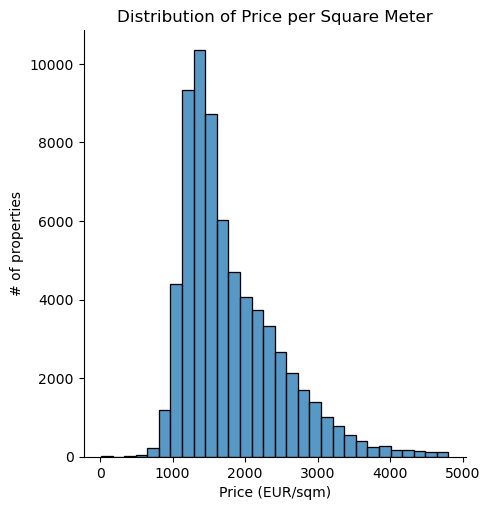

In [75]:
# Calculate the IQR of the price_EUR_sqm column
q1 = real_estate_df['price_EUR_sqm'].quantile(0.25)
q3 = real_estate_df['price_EUR_sqm'].quantile(0.75)
iqr = q3 - q1

# Calculate the upper and lower bounds for outliers
upper_bound = q3 + 3*iqr
lower_bound = q1 - 1.5*iqr

# Remove the outliers from the dataframe
real_estate_df = real_estate_df[(real_estate_df['price_EUR_sqm'] >= lower_bound) & (real_estate_df['price_EUR_sqm'] <= upper_bound)]

# Create a histogram of price_EUR_sqm
sns.displot(data=real_estate_df, x='price_EUR_sqm', bins=30)

# Set the x- and y-axis labels and title
plt.xlabel('Price (EUR/sqm)')
plt.ylabel('# of properties')
plt.title('Distribution of Price per Square Meter')

# Show the plot
plt.show()

#### Average Price per square meter by city

We used the `groupby()` function to group the original dataframe by 'localitate', and then applied a lambda function <br> 
to compute the sum of 'price_EUR' divided by the sum of 'useful_surface' for each group. We then used reset_index() to <br> 
convert the resulting series to a dataframe with columns 'localitate' and 'price_EUR_sqm'.
<br>
After computing the price per square meter by 'localitate', we created a bar plot using the barplot() function from seaborn as before.

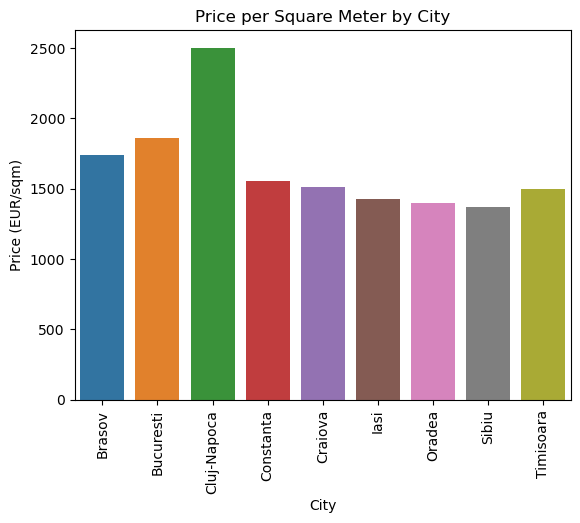

In [76]:
# Compute the price per square meter by localitate
df_ppsm = real_estate_df.groupby('localitate').apply(lambda x: x['price_EUR'].sum() / x['useful_surface'].sum()).reset_index(name='price_EUR_sqm')

# Create a bar plot of the price per square meter by localitate
sns.barplot(x='localitate', y='price_EUR_sqm', data=df_ppsm)

# Rotate the x-axis labels to avoid overlapping
plt.xticks(rotation=90)

# Set the x- and y-axis labels and title
plt.xlabel('City')
plt.ylabel('Price (EUR/sqm)')
plt.title('Price per Square Meter by City')

# Show the plot
plt.show()

#### Average Price per sqm by Construction Year

In this code, we used the same approach as before to compute the price per square meter by 'construction_year', <br>
and then filtered the results to keep only the most recent 20 years using sort_values() to sort by 'construction_year' <br>
in descending order and `iloc[]` to select the first 20 rows.<br>

After filtering the results, we created a bar plot as before, but with 'construction_year' on the x-axis instead of 'localitate'.

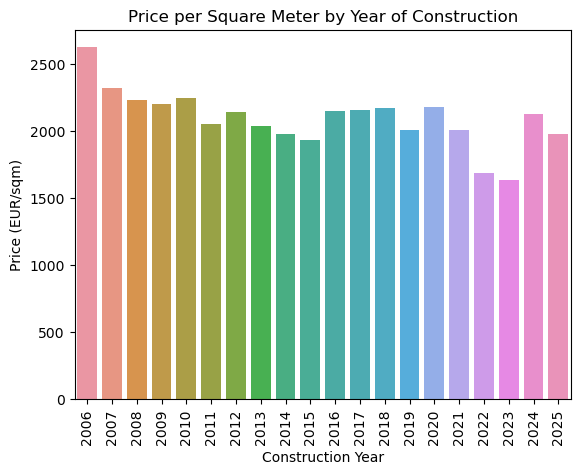

In [77]:
# Compute the price per square meter by construction_year
df_ppsm = real_estate_df.groupby('construction_year').apply(lambda x: x['price_EUR'].sum() / x['useful_surface'].sum()).reset_index(name='price_EUR_sqm')

# Filter to keep only the most recent 20 years
df_ppsm = df_ppsm.sort_values(by='construction_year', ascending=False).iloc[:20]

# Create a bar plot of the price per square meter by construction_year
sns.barplot(x='construction_year', y='price_EUR_sqm', data=df_ppsm)

# Rotate the x-axis labels to avoid overlapping
plt.xticks(rotation=90)

# Set the x- and y-axis labels and title
plt.xlabel('Construction Year')
plt.ylabel('Price (EUR/sqm)')
plt.title('Price per Square Meter by Year of Construction')

# Show the plot
plt.show()

#### Average Price per sqm by Partitioning

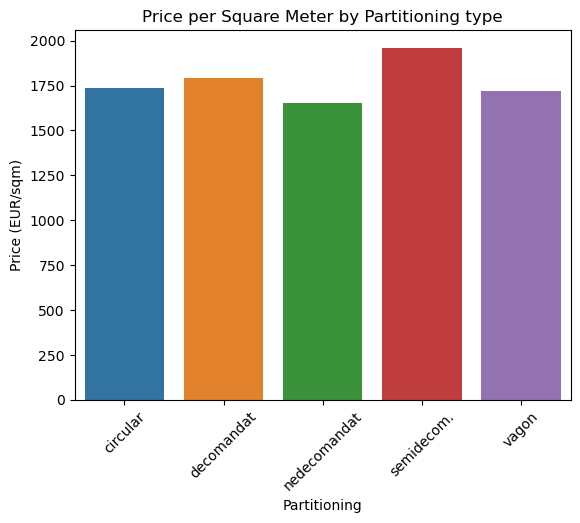

In [78]:
# Compute the price per square meter by partioning (or detachment)
df_ppsm = real_estate_df.groupby('partitioning').apply(lambda x: x['price_EUR'].sum() / x['useful_surface'].sum()).reset_index(name='price_EUR_sqm')

# Create a bar plot of the price per square meter by partioning
sns.barplot(x='partitioning', y='price_EUR_sqm', data=df_ppsm)

# Rotate the x-axis labels to avoid overlapping
plt.xticks(rotation=45)

# Set the x- and y-axis labels and title
plt.xlabel('Partitioning')
plt.ylabel('Price (EUR/sqm)')
plt.title('Price per Square Meter by Partitioning type')

# Show the plot
plt.show()

#### Average Price per sqm by Floor level

In [79]:
# Cast floor_level to int
real_estate_df['floor_level'] = real_estate_df['floor_level'].astype(int)

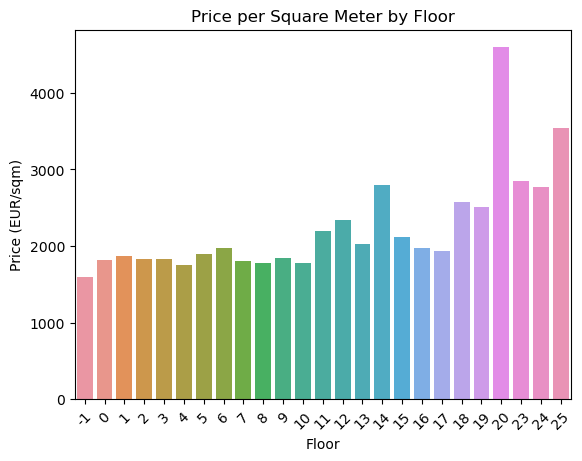

In [80]:
# Compute the price per square meter by parfloor_level
df_ppsm = real_estate_df.groupby('floor_level').apply(lambda x: x['price_EUR'].sum() / x['useful_surface'].sum()).reset_index(name='price_EUR_sqm')

# Create a bar plot of the price per square meter by partioning
sns.barplot(x='floor_level', y='price_EUR_sqm', data=df_ppsm)

# Rotate the x-axis labels to avoid overlapping
plt.xticks(rotation=45)

# Set the x- and y-axis labels and title
plt.xlabel('Floor')
plt.ylabel('Price (EUR/sqm)')
plt.title('Price per Square Meter by Floor')

# Show the plot
plt.show()

#### Correlation Matrix

In below code, `mask` is used to hide the upper triangle of the correlation matrix because it is symmetric.<br>
The `cmap` variable defines the color palette to be used for the heatmap.<br>
The `vmax` parameter sets the range of the color scale.<br>
The `annot` argument tells seaborn to include the correlation coefficients in each square of the heatmap.<br> 
The `fmt` argument specifies the format string for the coefficients, in this case to display them as floating-point numbers with two decimal places.<br>
Finally, we used `annot_kws={"size": 10}` to adjust the font size of the correlation coefficients.

C:\Users\Serghei.Dragan\AppData\Local\Temp\ipykernel_17180\299376518.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = real_estate_df.corr()
C:\Users\Serghei.Dragan\AppData\Local\Temp\ipykernel_17180\299376518.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


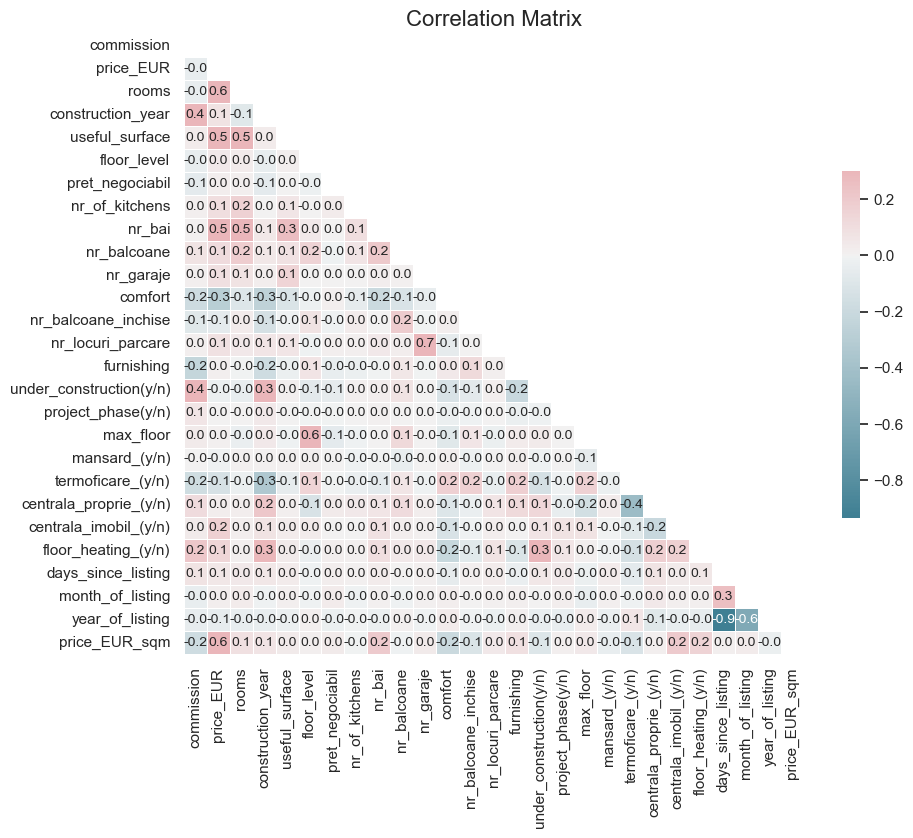

In [81]:
corr = real_estate_df.corr()
sns.set(style='white')
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".1f", annot_kws={"size": 10})
plt.title('Correlation Matrix', fontsize=16)

plt.show()

Due to high negative correlation between days_since_listing and year_of_listing the latter will be dropped toghether with month_of_listing.<br>
Same is applicable for nr_locuri_parcare and nr_garaje where we have a relatively high positive correlation. <br>
In terms of price_EUR_sqm and price_EUR the former is our target and the latter is derived by multiplying the target with the useful surface and as such we can delete the attribute price_EUR as well.

In [82]:
highly_correlated_columns = ['year_of_listing', 'month_of_listing', 'nr_garaje', 'price_EUR', 'date_of_listing']
real_estate_df.drop(columns=highly_correlated_columns, axis=1, inplace=True)

In [83]:
# Removing as well some attributes that the user might not be aware ahead of time in order to establish the price
real_estate_df.drop(columns=['commission', 'pret_negociabil', 'tip_client'], axis=1, inplace=True)

In [84]:
real_estate_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68059 entries, 0 to 69478
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   localitate               68059 non-null  object 
 1   zona                     68059 non-null  object 
 2   rooms                    68059 non-null  int32  
 3   construction_year        68059 non-null  int32  
 4   useful_surface           68059 non-null  float64
 5   floor_level              68059 non-null  int32  
 6   nr_of_kitchens           68059 non-null  int64  
 7   nr_bai                   68059 non-null  int64  
 8   nr_balcoane              68059 non-null  int64  
 9   partitioning             68059 non-null  object 
 10  comfort                  68059 non-null  int32  
 11  nr_balcoane_inchise      68059 non-null  int64  
 12  structura_rezistenta     68059 non-null  object 
 13  tip_imobil               68059 non-null  object 
 14  nr_locuri_parcare     

In [85]:
# Export data to csv file
real_estate_df.to_csv('processed_data_real_estate.csv')

Applying LabelEncoder for categorical columns

In [86]:
# Selecting categorical columns
object_attributes = [cat for cat in real_estate_df.columns if real_estate_df[cat].dtypes == 'object']
object_attributes

['localitate', 'zona', 'partitioning', 'structura_rezistenta', 'tip_imobil']

In [87]:
# Creating an instance of LabelEncoder class
le = LabelEncoder()
# Applying LabelEncoder to categorical columns
for cat in object_attributes:
    real_estate_df[cat] = le.fit_transform(real_estate_df[cat])

### Selection of model generation techniques

As the purpose of the task is to predict a cotinuos variable we need models that can perform regression (not classification). <br>
The candidates in this case will be three models as follows:<br>
* Random Forest Regression
* XGBRegressor
* Gradient Boosting Regression

### Generating the test design:

In this code, X represents the feature matrix and Y represents the target variable.<br>
The train_test_split function is called twice: first to split the data into training/validation/test sets with a 80/20 split (i.e., test_size=0.2), <br>and then to split the training/validation sets further into separate training and validation sets with a 85/15 split (i.e., test_size=0.15).

The random_state parameter sets the random seed for reproducibility.

After splitting the data, we can use the training set to train the models, the validation set to tune the models, and the test set to evaluate the performance of the models on unseen data.

In [88]:
# Separate target variable from predictors
X = real_estate_df.drop('price_EUR_sqm', axis=1)
Y = real_estate_df['price_EUR_sqm']

In [89]:
# Split the data into train, validation and test with a ratio of 68/12/20
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.15, random_state=42)

In this example, we fit the scaler to the training set using the fit_transform() method, which computes the mean and standard deviation of the training set and scales the data accordingly. We then use the transform() method to scale the validation and test sets, using the same scaler that was fit to the training set.

The reason we apply the StandardScaler after splitting the data set into training, validation, and test sets is to avoid data leakage. If we scale the data before splitting, we would be using information from the validation and test sets to standardize the training set, which is not allowed.

Scaling the training set only ensures that the mean and variance of the training set are centered around 0 and have a standard deviation of 1. We then use the same scaler to transform the validation and test sets. This way, we are only using information from the training set to standardize the data, and the validation and test sets remain unseen until the final evaluation.

In [90]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [91]:
# Checking the shape of splitted data sets
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)

print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (46279, 25)
Y_train shape: (46279,)
X_val shape: (8168, 25)
Y_val shape: (8168,)
X_test shape: (13612, 25)
Y_test shape: (13612,)


### Model Building - RandomForestRegressor

In [92]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [93]:
# Initialize the Random Forest Regressor model with default parameters
rf_model = RandomForestRegressor(random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, Y_train)

# Evaluate the model on the training data
Y_train_pred = rf_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
train_r2 = r2_score(Y_train, Y_train_pred)

# Evaluate the model on the validation data
Y_val_pred = rf_model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(Y_val, Y_val_pred))
val_r2 = r2_score(Y_val, Y_val_pred)

print(f"Random Forest Regressor - Training RMSE: {train_rmse:.2f}, Training R^2: {train_r2:.2f}")
print(f"Random Forest Regressor - Validation RMSE: {val_rmse:.2f}, Validation R^2: {val_r2:.2f}")

Random Forest Regressor - Training RMSE: 135.42, Training R^2: 0.96
Random Forest Regressor - Validation RMSE: 355.75, Validation R^2: 0.72


A validation RMSE of 358 is relatively high compared to the training RMSE of 135, indicating that the model may be overfitting the training data.<br> Tuning the hyperparameters of the model can help to improve its performance on the validation set.

### Options to avoid overfitting:

1. Use more training data: Overfitting can occur when the model is trained on a small dataset that does not represent the true population well. Collecting more data can help the model generalize better and avoid overfitting.

2. Reduce the number of features: The more features the model has, the more likely it is to overfit. Try to reduce the number of features to the most relevant ones.

3. Limit the depth of the trees: Random forests can create very deep trees that overfit the data. Setting a maximum depth or limiting the number of nodes in each tree can help reduce overfitting.

4. Increase the number of trees: Increasing the number of trees in the forest can improve the model's generalization ability and reduce overfitting.

5. Use cross-validation: Cross-validation can help to assess the model's generalization ability and tune hyperparameters to avoid overfitting.

6. Regularize the model: Adding regularization terms, such as L1 or L2 regularization, to the model's objective function can help prevent overfitting.

7. Use ensemble techniques: Ensembling can help to reduce overfitting by combining the predictions of multiple models with different parameters or architectures. This can improve the model's generalization ability and reduce the risk of overfitting.

Point 1 related to using more training data is not valid in this case as 70% of data was used for training and it can't be increased futher as 10% was reserved for validation while the remaining 20% for test.<br>

For point 2 we will use `RFECV` which stands for `Recursive Feature Elimination with Cross-Validation`. It is a technique for feature selection that recursively removes less important features from the dataset while performing `cross-validation` to evaluate the model's performance. The process continues until the optimal number of features is reached.

Points 3-6 are all related to tuning the hyperparameters of the model and in the case of `RandomForestRegressor` we are planning to use a technique called `RandomizedSearchCV`.

Point 7 is resource intensive and too time consuming for this stage but should be explored as a next step in order to get the best robust model possible.

### Trying different approaches for improving model performance but especially to reduce overfitting

### Tuning the model's Hyperparameters

The hyperparameters that we can tune for a Random Forest Regressor include:

* `n_estimators`: the number of trees in the forest
* `max_depth`: the maximum depth of each tree
* `min_samples_split`: the minimum number of samples required to split an internal node
* `min_samples_leaf`: the minimum number of samples required to be at a leaf node (`L1 regularization`)
* `ccp_alpha`: sets the strength of the `L2 regularization` term

There are different types of regularization techniques that can be used with the RandomForestRegressor algorithm to prevent overfitting:

* L1 regularization: L1 regularization adds a penalty term equal to the absolute value of the weights. This type of regularization encourages the model to select only the most important features and sets the weights of less important features to zero.

* L2 regularization: L2 regularization adds a penalty term equal to the square of the weights. This type of regularization encourages the model to spread the weights across all features and prevents the model from overemphasizing any single feature.

The `RandomizedSearchCV` randomly selects a subset of hyperparameters to evaluate instead of exhaustively searching through all possible combinations, which can lead to faster hyperparameter tuning. For each combination randomly selected, the code will fit a Random Forest Regressor on the training set and evaluate its performance on the validation set using 5-fold cross validation. The best combination of hyperparameters will be the one that minimizes the RMSE on the validation set.

The parameter `cv=5` in the `RandomizedSearchCV` function specifies that we want to use 5-fold cross-validation. This means that the training set is divided into 5 equal parts or folds. The model is trained on 4 of the folds and evaluated on the remaining fold (i.e., validation set). This process is repeated 5 times, with each fold being used as the validation set once, and the results are averaged to obtain an estimate of the model's performance on the validation set.

So, although we don't explicitly use a separate validation set, we are using cross-validation to simulate the process of training the model on one subset of the data and evaluating its performance on a different subset.

In [97]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the hyperparameters to tune
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [None] + list(randint(5, 50).rvs(5)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=rf_model, 
                                   param_distributions=param_dist, 
                                   n_iter=20, 
                                   cv=5, 
                                   random_state=42,
                                   scoring='neg_root_mean_squared_error')

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, Y_train)

# Print the best hyperparameters and the corresponding RMSE on the validation set
print("Best Hyperparameters:", random_search.best_params_)
print("Validation RMSE:", -random_search.best_score_)


Best Hyperparameters: {'max_depth': 21, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 665}
Validation RMSE: 375.83307806724616


In this example, we define the hyperparameters using a dictionary and a set of probability distributions from the scipy.stats module. We then create a RandomizedSearchCV object and fit it to the training data. The n_iter parameter controls the number of random searches to perform, and the cv parameter specifies the number of cross-validation folds to use.

RandomizedSearchCV can be faster than GridSearchCV, but it's important to note that it may not necessarily find the best hyperparameters since it doesn't search all possible combinations. However, it can be a good option when the search space is large or when the training time is limited.

### Next steps after the best Hyperparameters are found

After finding the best hyperparameters using cross-validation, we can use them to evaluate model performance on the validation set. We can subsequently use the same hyperparameters and fit the model on the entire training set and evaluate its performance on the test set, which will give us a good estimate of the model's performance on new, unseen data if the results on validation are satisfactory.

In [98]:
# Get the best model from the randomized search
best_model = random_search.best_estimator_

# Make predictions on the validation data
Y_pred = best_model.predict(X_val)

# Calculate RMSE and R2 score on the validation data
rmse = mean_squared_error(Y_val, Y_pred, squared=False)
r2 = r2_score(Y_val, Y_pred)

print("Validation RMSE:", rmse)
print("Validation R2 score:", r2)

Validation RMSE: 364.7301380629408
Validation R2 score: 0.7034973180943803


### Feature reduction (or selection)

We can get the feature_importances_ attribute of the trained rf_model object using the code below.<br> This will print an array of feature importances, where the index of each value corresponds to the index of the column in the input data X.

In [99]:
# Get feature importances
feature_importances = best_model.feature_importances_
print(feature_importances)

[2.64841344e-01 1.72637712e-01 9.33515452e-03 9.95644258e-02
 7.31669274e-02 3.73788462e-02 7.45614723e-04 4.28503699e-02
 1.75540346e-02 8.01433513e-03 8.32652788e-02 7.75754600e-03
 1.79323980e-03 9.87247937e-03 1.33949361e-02 4.12716463e-03
 1.98713373e-04 5.19923290e-02 6.88596629e-04 1.63789432e-03
 1.19957298e-02 1.55845345e-02 1.93081271e-02 5.22946662e-02]


We can also create a Pandas DataFrame to better visualize the feature importances as decided by the model:

In [100]:
# Get feature importances
importances = best_model.feature_importances_

# Create DataFrame of feature importances
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
# Sort the features by importance
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Print features
print(feature_importances)

                    feature  importance
0                localitate    0.264841
1                      zona    0.172638
3         construction_year    0.099564
10                  comfort    0.083265
4            useful_surface    0.073167
23       days_since_listing    0.052295
17                max_floor    0.051992
7                    nr_bai    0.042850
5               floor_level    0.037379
22      floor_heating_(y/n)    0.019308
8               nr_balcoane    0.017554
21    centrala_imobil_(y/n)    0.015585
14               furnishing    0.013395
20   centrala_proprie_(y/n)    0.011996
13        nr_locuri_parcare    0.009872
2                     rooms    0.009335
9              partitioning    0.008014
11     structura_rezistenta    0.007758
15  under_construction(y/n)    0.004127
12               tip_imobil    0.001793
19        termoficare_(y/n)    0.001638
6            nr_of_kitchens    0.000746
18            mansard_(y/n)    0.000689
16       project_phase(y/n)    0.000199


As tuning algorithms' hyperparameters have not improved the RMSE compared to the default parameters we well try another approach like feature selection using RFECV to improve model's performance.<br>
RFECV is a modified version of RFEC that can estimate the optimal number of features to select using cross-validation. It's a more robust method than simply using RFE (which requires the user to specify the number of features to select), as it helps prevent overfitting and also gives us a more accurate estimate of the optimal number of features to select.

In [101]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor

# Get the best hyperparameters from randomized search:
best_params = random_search.best_params_

# Create the best random forest regressor
best_rf_model = RandomForestRegressor(**best_params, random_state=42)

# Create a recursive feature elimination object
rfecv = RFECV(estimator=best_rf_model, cv=5, scoring='neg_root_mean_squared_error')

# Fit the recursive feature elimination object to the training data
rfecv.fit(X_train, Y_train)

RFECV(cv=5,
      estimator=RandomForestRegressor(max_depth=21, min_samples_leaf=2,
                                      min_samples_split=7, n_estimators=665,
                                      random_state=42),
      scoring='neg_root_mean_squared_error')

Selected Features: Index(['localitate', 'zona', 'construction_year', 'useful_surface',
       'floor_level', 'nr_bai', 'comfort', 'max_floor', 'days_since_listing'],
      dtype='object')


C:\Users\Serghei.Dragan\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


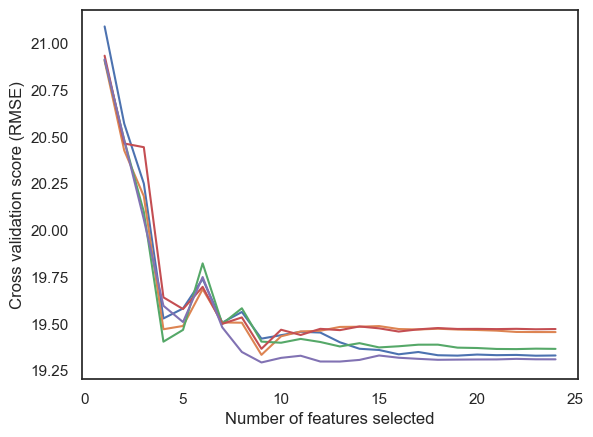

In [102]:
# Convert X_train back to a dataframe
X_train_df = pd.DataFrame(X_train, columns=X.columns)

# Print the selected features
print("Selected Features:", X_train_df.columns[rfecv.support_])

# Plot the number of features vs. cross-validation scores
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (RMSE)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), np.sqrt(-rfecv.grid_scores_))
plt.show()

The code above fits the `RandomForestRegressor` with best hyperparameters found to the training data and perform recursive feature elimination using cross-validation. The `RFECV` object will select the optimal number of features using the `cv` parameter (in this case, 5-fold cross-validation). The `support_` attribute of the `RFECV` object contains a boolean mask of the selected features. The code also generates a plot of the number of features vs. the cross-validation score (RMSE).

We can adjust the parameters of `RFECV` to suit our needs, such as the `step` parameter to control how many features are removed at each iteration, or the `min_features_to_select` parameter to set a lower limit on the number of features to select.

### Checking against Validation data set again

Once we have identified the top features using RFECV, we can use them to train a new instance of the `RandomForestRegressor` model on the training set `X_train` and `Y_train`.<br> Here is the code to create a new model with only the selected features and then train it on the training set:

In [103]:
# Select only the top features identified by RFECV
selected_features = X_train_df.columns[rfecv.support_]

In [104]:
# Create a new training set with only the selected features
X_train_selected = X_train_df[selected_features]

# Create a new random forest model with the same hyperparameters as the best model
new_rf_model = RandomForestRegressor(**best_params, random_state=42)

# Train the new model on the selected features and training set
new_rf_model.fit(X_train_selected, Y_train)

RandomForestRegressor(max_depth=21, min_samples_leaf=2, min_samples_split=7,
                      n_estimators=665, random_state=42)

Once the new model is trained, we can use it to predict on the validation set `X_val` and compare the predicted values with the actual values `Y_val`.<br>
This will give us the RMSE of the new model on the validation set. If the RMSE is lower than the previous model's RMSE, then the new model is a better fit for the data.

In [105]:
# Convert X_train back to a dataframe
X_val_df = pd.DataFrame(X_val, columns=X.columns)

# Use the new model to predict on the validation set
X_val_selected = X_val_df[selected_features]
Y_pred = new_rf_model.predict(X_val_selected)

# Evaluate the model's performance on the validation set
rmse = mean_squared_error(Y_val, Y_pred, squared=False)
r2 = r2_score(Y_val, Y_pred)
print("RMSE on validation set:", rmse)
print("R^2 on validation set:", r2)

RMSE on validation set: 363.8831794393808
R^2 on validation set: 0.7048727675099583


The results have not improved and are almost similar, however, this solution helped in reducing the data frame to just 8 attributes out of 25 giving a similar performance.

### Select model version and test it on Test data and Evaluate Performance

Below is the code to train a final Random Forest Regressor on the entire training set using the selected hyperparameters.

In [94]:
# Make predictions on the test set
Y_pred_test = rf_model.predict(X_test)

# Calculate RMSE and R2 score on the test set
rmse_test = mean_squared_error(Y_test, Y_pred_test, squared=False)
r2_test = r2_score(Y_test, Y_pred_test)

# Print results
print("RMSE on test set for RandomForestRegressor is:", rmse_test)
print("R^2 on test set RandomForestRegressor is:", r2_test)

RMSE on test set for RandomForestRegressor is: 360.2172089484895
R^2 on test set RandomForestRegressor is: 0.7156790907391968


### Model Building - XGBRegressor

In [107]:
# Import necessary packages
from xgboost import XGBRegressor

# Initialize the XGBoost regressor model
xgb_model = XGBRegressor(random_state=42)

Fitting the model with its default parameters and evaluating the performance on both training and validation partitions

In [108]:
# Fit the XGBoost regressor model on the training data
xgb_model.fit(X_train, Y_train)

# Evaluate the model on the training data
Y_train_pred = xgb_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
train_r2 = r2_score(Y_train, Y_train_pred)

# Evaluate the model on the validation data
Y_val_pred = xgb_model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(Y_val, Y_val_pred))
val_r2 = r2_score(Y_val, Y_val_pred)

print(f"XGBoost Regressor - Training RMSE: {train_rmse:.2f}, Training R^2: {train_r2:.2f}")
print(f"XGBoost Regressor - Validation RMSE: {val_rmse:.2f}, Validation R^2: {val_r2:.2f}")

XGBoost Regressor - Training RMSE: 301.09, Training R^2: 0.80
XGBoost Regressor - Validation RMSE: 357.02, Validation R^2: 0.72


Hyperparameter tuning with RandomizedSearchCV

In [109]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# Define hyperparameter ranges to search over
param_distributions = {
    'n_estimators': [100, 500, 1000, 1500, 2000],
    'max_depth': [1, 3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.5, 0.7, 1],
    'colsample_bytree': [0.3, 0.5, 0.7, 1],
    'subsample': [0.3, 0.5, 0.7, 1],
    'gamma': [0, 0.1, 0.5, 1]
}

# Create an instance of the XGBRegressor
xgb = XGBRegressor(random_state=42)

# Perform the random search with 20 iterations
random_search = RandomizedSearchCV(xgb, 
                                   param_distributions=param_distributions, 
                                   n_iter=20, 
                                   scoring='neg_mean_squared_error', 
                                   n_jobs=-1, 
                                   cv=5, 
                                   random_state=42)

# Fit the model on the training set
random_search.fit(X_train, Y_train)

# Print the best hyperparameters and corresponding score
print('Best parameters: ', random_search.best_params_)
print('Best score: ', np.sqrt(-random_search.best_score_))

Best parameters:  {'subsample': 1, 'n_estimators': 1000, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.7}
Best score:  323.4896998588947


Creating a new model using the best parameters found on evaluating it.

Note that we use the double asterisks ** to unpack the dictionary of best hyperparameters into the arguments of the XGBRegressor constructor.<br> This way, we don't have to manually write the hyperparameters into the code.

In [110]:
# Extract the best hyperparameters found by RandomizedSearchCV
best_params_xgb = random_search.best_params_

# Create a new instance of the XGBRegressor with the best hyperparameters
xgb_train = XGBRegressor(**best_params_xgb, random_state=42)

# Fit the model on the training dataset
xgb_train.fit(X_train, Y_train)

# Evaluate the performance of the model on the validation set
Y_val_pred_hyper = xgb_train.predict(X_val)
val_rmse_hyper = np.sqrt(mean_squared_error(Y_val, Y_val_pred_hyper))
val_r2_hyper = r2_score(Y_val, Y_val_pred_hyper)
print('XGBoost Regressor - Validation RMSE with tuning: {:.2f}, Validation R^2 with tuning: {:.2f}'.format(val_rmse_hyper, val_r2_hyper))

XGBoost Regressor - Validation RMSE with tuning: 312.81, Validation R^2 with tuning: 0.78


Fitting the model on the whole training data set (i.e, training + validation)

In [111]:
# Create another instance of the XGBRegressor with the best hyperparameters
xgb = XGBRegressor(**best_params_xgb, random_state=42)

# Concatenate X_train and X_val
X_train_val = np.concatenate((X_train, X_val), axis=0)
Y_train_val = np.concatenate((Y_train, Y_val), axis=0)

# Fit the model on the concatenated training dataset
xgb.fit(X_train_val, Y_train_val)

# Evaluate the performance of the model on the training set and validation set altogether
Y_train_val_pred = xgb.predict(X_train_val)
train_val_rmse = np.sqrt(mean_squared_error(Y_train_val, Y_train_val_pred))
train_val_r2 = r2_score(Y_train_val, Y_train_val_pred)
print('XGBoost Regressor - Train/Validation RMSE with tuning: {:.2f}, Train/Validation R^2 with tuning: {:.2f}'.format(train_val_rmse, train_val_r2))

XGBoost Regressor - Train/Validation RMSE with tuning: 97.23, Train/Validation R^2 with tuning: 0.98


Evaluating the model on Test dataset

In [112]:
# Predict test targets using the last developed model
Y_test_pred = xgb.predict(X_test)

# Evaluate the performance of the model on the held-out test set
test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))
test_r2 = r2_score(Y_test, Y_test_pred)
print('XGBoost Regressor - Test RMSE: {:.2f}, Test R^2: {:.2f}'.format(test_rmse, test_r2))

XGBoost Regressor - Test RMSE: 303.10, Test R^2: 0.80


### Model Building - Gradient Boosting Regressor

In [113]:
# import libraries
from sklearn.ensemble import GradientBoostingRegressor

In [114]:
gb_regressor = GradientBoostingRegressor(random_state=42)
gb_regressor.fit(X_train, Y_train)

# Make predictions on training set
Y_train_preds = gb_regressor.predict(X_train)

# Evaluate the model on training set
train_rmse = mean_squared_error(Y_train, Y_train_preds, squared=False)
train_r2 = r2_score(Y_train, Y_train_preds)

print("Gradient Boosting Regressor - Training RMSE: {:.2f}, Training R^2: {:.2f}".format(train_rmse, train_r2))

Gradient Boosting Regressor - Training RMSE: 458.71, Training R^2: 0.54


In [115]:
# Make predictions on validation set
Y_val_preds = gb_regressor.predict(X_val)

# Evaluate the model on validation set
val_rmse = mean_squared_error(Y_val, Y_val_preds, squared=False)
val_r2 = r2_score(Y_val, Y_val_preds)

print("Gradient Boosting Regressor - Validation RMSE: {:.2f}, Validation R^2: {:.2f}".format(val_rmse, val_r2))

Gradient Boosting Regressor - Validation RMSE: 455.98, Validation R^2: 0.54


Final testing

In [116]:
# Make predictions on test set
Y_test_preds = gb_regressor.predict(X_test)

# Evaluate the model on test set
test_rmse = mean_squared_error(Y_test, Y_test_preds, squared=False)
test_r2 = r2_score(Y_test, Y_test_preds)

print("Gradient Boosting Regressor - Test RMSE: {:.2f}, Test R^2: {:.2f}".format(test_rmse, test_r2))

Gradient Boosting Regressor - Test RMSE: 455.40, Test R^2: 0.54
